In [1]:
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [379]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        #image = mpimg.imread(file)#wrong to use this
        #image = image.astype(np.float32)/255
        image = cv2.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                    #hog_features.append(get_hog_features((cv2.flip(feature_image,1))[:,:,channel], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True))                    
                hog_features = np.ravel(hog_features)        
            else:

                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                #hog_features = get_hog_features((cv2.flip(feature_image,1))[:,:,channel], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)                
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


In [3]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    
    

In [18]:
# Divide up into cars and notcars
cars = glob.glob('vehicles/*/*')
notcars = glob.glob('non-vehicles/*/*')
print(len(cars))
print(len(notcars))

8792
8968


'\ncolor_space = \'YUV\' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb\norient = 11  # HOG orientations\npix_per_cell = 16 # HOG pixels per cell\ncell_per_block = 2 # HOG cells per block\nhog_channel = "ALL" # Can be 0, 1, 2, or "ALL"\nspatial_size = (16, 16) # Spatial binning dimensions\nhist_bins = 32    # Number of histogram bins\nspatial_feat = True # Spatial features on or off\nhist_feat = True # Histogram features on or off\nhog_feat = True # HOG features on or off\ny_start_stop = [450, 720]\n'

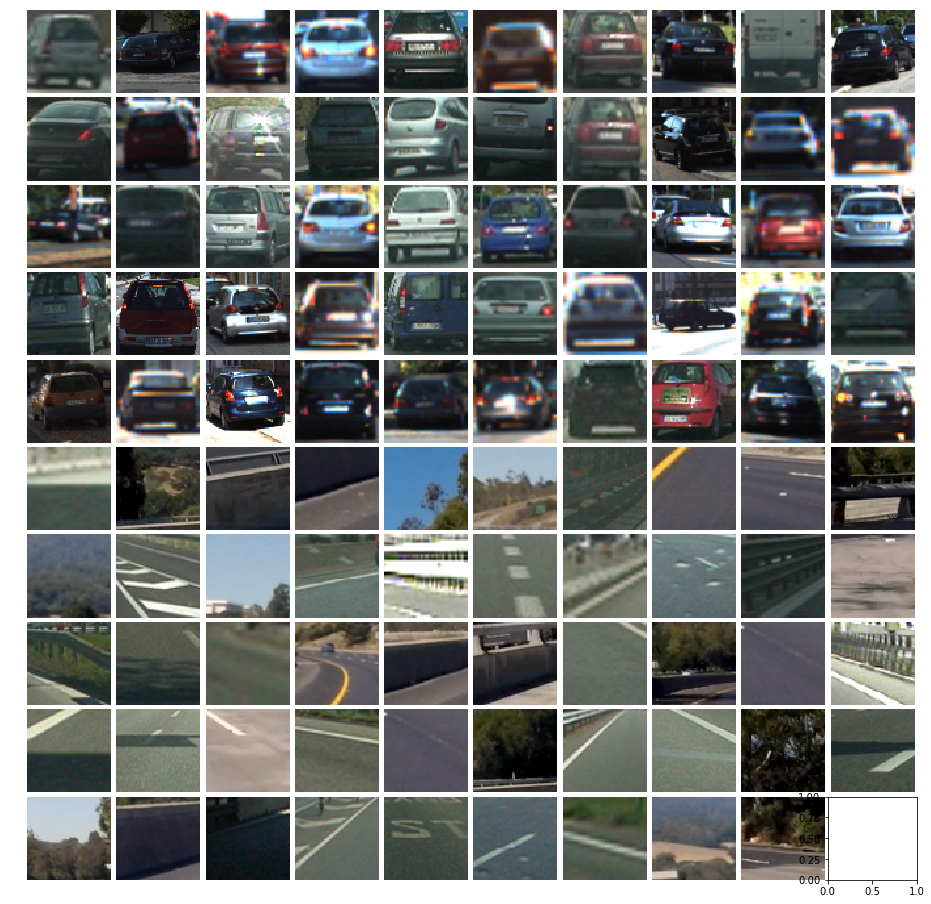

In [736]:
fig, axes = plt.subplots(10,10, figsize=(16, 16))
fig.subplots_adjust(hspace = 0.05, wspace=0.001)
axs = axes.ravel()
for i in range(50):
    img = cv2.imread(cars[np.random.randint(0,len(notcars))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].imshow(img)
for i in range(50,99):
    img = cv2.imread(notcars[np.random.randint(0,len(notcars))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].imshow(img)
plt.savefig('output_images/car_not_car.jpg')

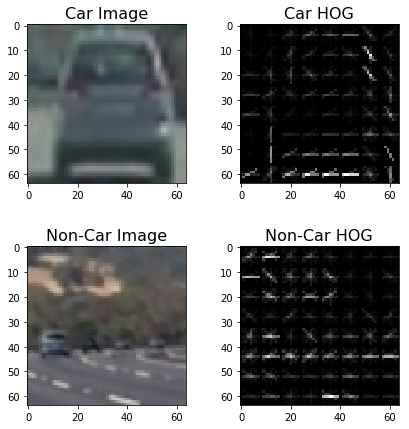

In [65]:
car_img = mpimg.imread(cars[5])
eg_car_features,car_hog=get_hog_features(car_img[:,:,0], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)
noncar_img = mpimg.imread(notcars[465])
eg_noncar_features,noncar_hog=get_hog_features(noncar_img[:,:,0], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_hog, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(noncar_img)
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(noncar_hog, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=16)
plt.savefig('output_images/HOG_example.jpg')

In [599]:
'''extract feature'''

color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 10  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 720]

t=time.time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

print(car_features[1].shape,len(car_features))


'''train a classifier'''
# Create an array stack, NOTE: StandardScaler() expects np.float64
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)


print('Using:',color_space,'color_space',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block',
      hog_channel,'hog_channel',hog_feat,'hog_feat',
      spatial_size,'spatial_size',spatial_feat,'spatial_feat',
      hist_bins,'hist_bins',hog_feat,'hog_feat',
      y_start_stop,'y_start_stop')

print('Feature vector length:', len(X_train[0]),
     'Train set length:',len(X_train),
     'Test set length:',len(X_test))
# Use a linear SVC 
#svc = LinearSVC()
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


106.64 Seconds to extract HOG features...
(4200,) 8792
Using: LUV color_space 10 orientations 16 pixels per cell and 2 cells per block ALL hog_channel True hog_feat (32, 32) spatial_size True spatial_feat 16 hist_bins True hog_feat [400, 720] y_start_stop
Feature vector length: 4200 Train set length: 14208 Test set length: 3552
11.46 Seconds to train SVC...
Test Accuracy of SVC =  0.9935


In [470]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars_boxes(img,color_space, ystart, ystop, xstart,xstop,scale, svc, X_scaler, 
                    orient, pix_per_cell, cell_per_block, cells_per_step , spatial_size, hist_bins):
    boxes=[]
    #draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    #ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    #ctrans_tosearch = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if color_space != 'RGB':
        if color_space == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img_tosearch)  
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch


            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
   
            test_prediction = 1
            
            if test_prediction == 1 :
                xbox_left = np.int(xleft*scale)+xstart
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                boxes.append(((int(xbox_left), int(ytop_draw+ystart)),(int(xbox_left+win_draw),
                                                                       int(ytop_draw+win_draw+ystart))))
    return boxes


4.47 Seconds to predict samples...


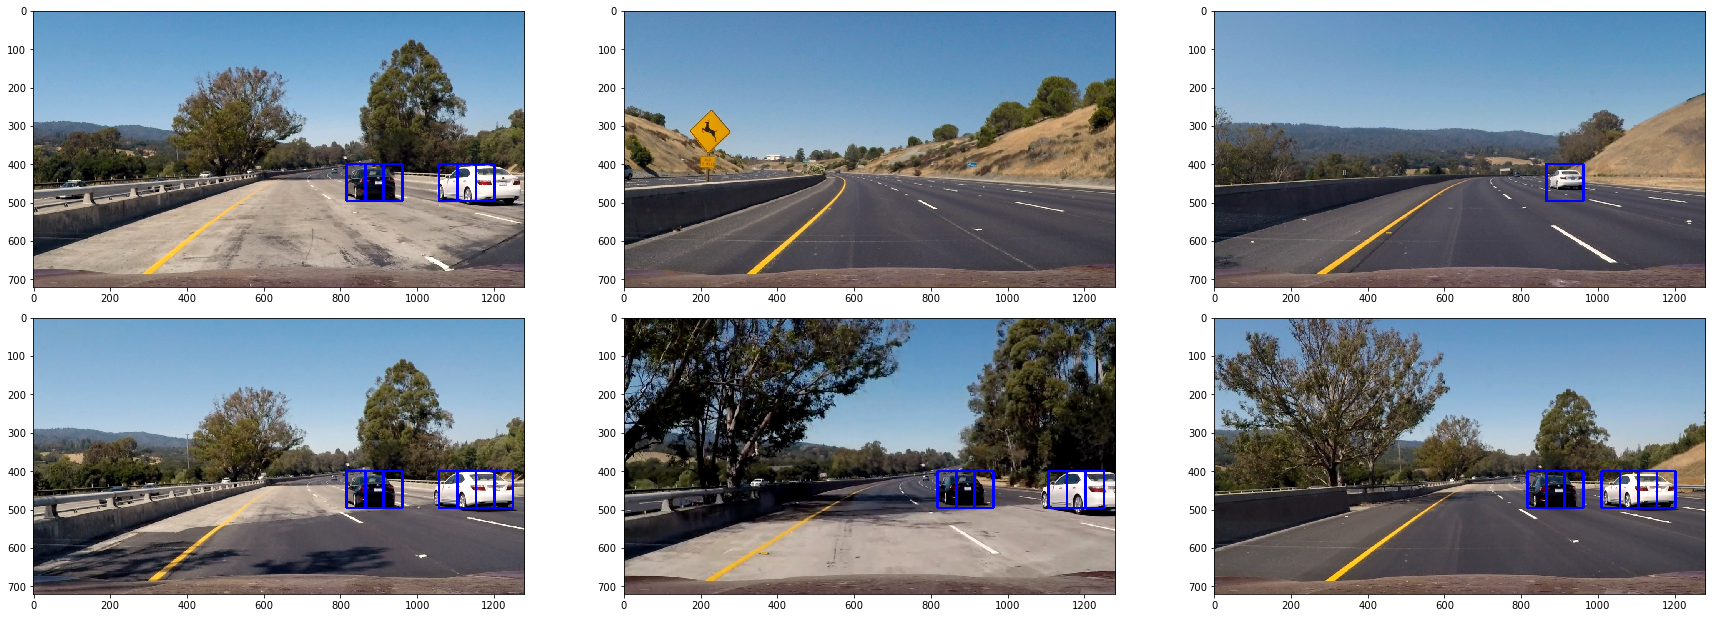

In [403]:
# Check the prediction time
t=time.time()
test_imgs = glob.glob('test_images/*')
i=0
f, axes = plt.subplots(2, 3, figsize=(24, 9))
f.tight_layout()
for fname in test_imgs:
    img = cv2.imread(fname)
    #img = mpimg.imread(fname)
    #img = img.astype(np.float32)*255
    draw_image = np.copy(img)
    
    #draw_image=cv2.cvtColor(draw_image, cv2.COLOR_BGR2RGB)
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    #image = image.astype(np.float32)/255

    windows = slide_window(draw_image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(96, 96), xy_overlap=(0.5, 0.5))
    hot_windows = []

    hot_windows += (search_windows(draw_image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat))                      

    draw_image=cv2.cvtColor(draw_image, cv2.COLOR_BGR2RGB)
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)       


    axes[i//3,i%3].imshow(window_img)
    i+=1
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.savefig('output_images/sliding_window.jpg')
t2 = time.time()
print(round(t2-t, 2), 'Seconds to predict samples...')

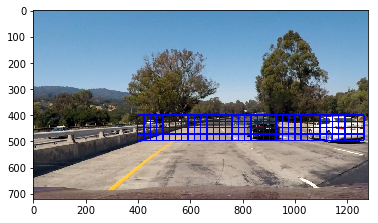

In [672]:
'''test scale windows'''
img = cv2.imread(test_imgs[0])
boxes=[]

cells_per_step=2
ystart = 400#400
ystop = 496#656
xstart=400
xstop=1280
scale =0.75
boxes.extend(find_cars_boxes(img, color_space,ystart, ystop, xstart,xstop,scale, svc, X_scaler, orient, 
                             pix_per_cell, cell_per_block,cells_per_step, spatial_size, hist_bins))

draw_img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#out_img=draw_boxes(draw_img, boxes, color=(0, 0, 255), thick=6)
out_img=draw_boxes(draw_img, boxes, color=(0, 0, 255), thick=3)
#plt.figure(figsize=(8,16))
plt.imshow(out_img)
plt.savefig('output_images/sliding_window_boxes.jpg')

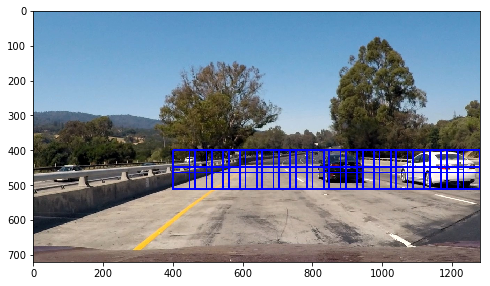

In [490]:
'''test scale windows'''
img = cv2.imread(test_imgs[0])
boxes=[]

cells_per_step=3
ystart = 400#400
ystop = 512#656
xstart=400
xstop=1280
scale =1
boxes.extend(find_cars_boxes(img, color_space,ystart, ystop, xstart,xstop,scale, svc, X_scaler, orient, 
                             pix_per_cell, cell_per_block,cells_per_step, spatial_size, hist_bins))

draw_img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#out_img=draw_boxes(draw_img, boxes, color=(0, 0, 255), thick=6)
out_img=draw_boxes(draw_img, boxes, color=(0, 0, 255), thick=3)
plt.figure(figsize=(8,16))
plt.imshow(out_img)


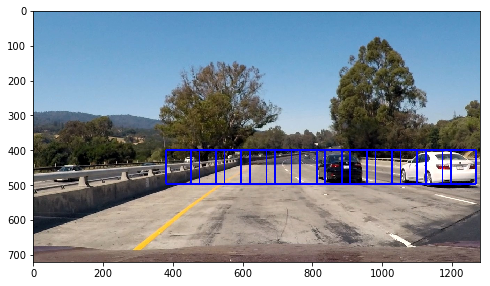

In [491]:
'''test scale windows'''
img = cv2.imread(test_imgs[0])
boxes=[]
cells_per_step=3
ystart = 400#400
ystop = 532#656
xstart=380
xstop=1280
scale =1.5
boxes.extend(find_cars_boxes(img, color_space,ystart, ystop, xstart,xstop,scale, svc, X_scaler, orient, 
                             pix_per_cell, cell_per_block,cells_per_step, spatial_size, hist_bins))

draw_img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
out_img=draw_boxes(draw_img, boxes, color=(0, 0, 255), thick=3)

plt.figure(figsize=(8,16))
plt.imshow(out_img)

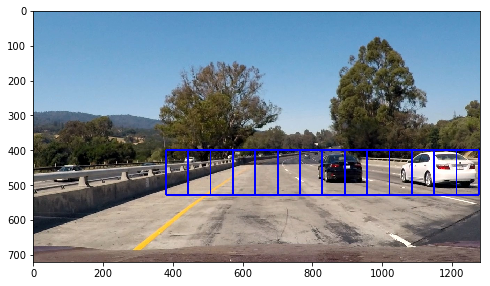

In [494]:
'''test scale windows'''
img = cv2.imread(test_imgs[0])
boxes=[]
cells_per_step=2
ystart = 400#400
ystop = 564#656
xstart=380
xstop=1280
scale =2
boxes.extend(find_cars_boxes(img, color_space,ystart, ystop, xstart,xstop,scale, svc, X_scaler, orient, 
                             pix_per_cell, cell_per_block,cells_per_step, spatial_size, hist_bins))

draw_img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#out_img=draw_boxes(draw_img, boxes, color=(0, 0, 255), thick=6)
out_img=draw_boxes(draw_img, boxes, color=(0, 0, 255), thick=3)
plt.figure(figsize=(8,16))
plt.imshow(out_img)

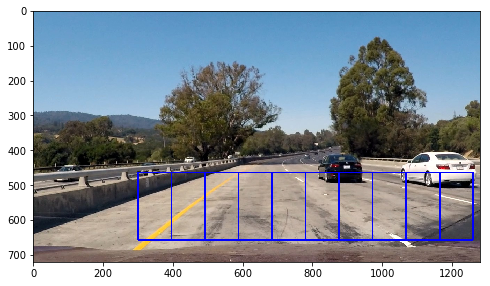

In [495]:
'''test scale windows'''
img = cv2.imread(test_imgs[0])
boxes=[]

ystart = 464#400
ystop = 700#656
xstart=300
xstop=1280
scale =3
boxes.extend(find_cars_boxes(img, color_space,ystart, ystop, xstart,xstop,scale, svc, X_scaler, orient, 
                             pix_per_cell, cell_per_block,cells_per_step, spatial_size, hist_bins))
draw_img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#out_img=draw_boxes(draw_img, boxes, color=(0, 0, 255), thick=6)
out_img=draw_boxes(draw_img, boxes, color=(0, 0, 255), thick=3)
plt.figure(figsize=(8,16))
plt.imshow(out_img)

4.3 Seconds to predict samples...


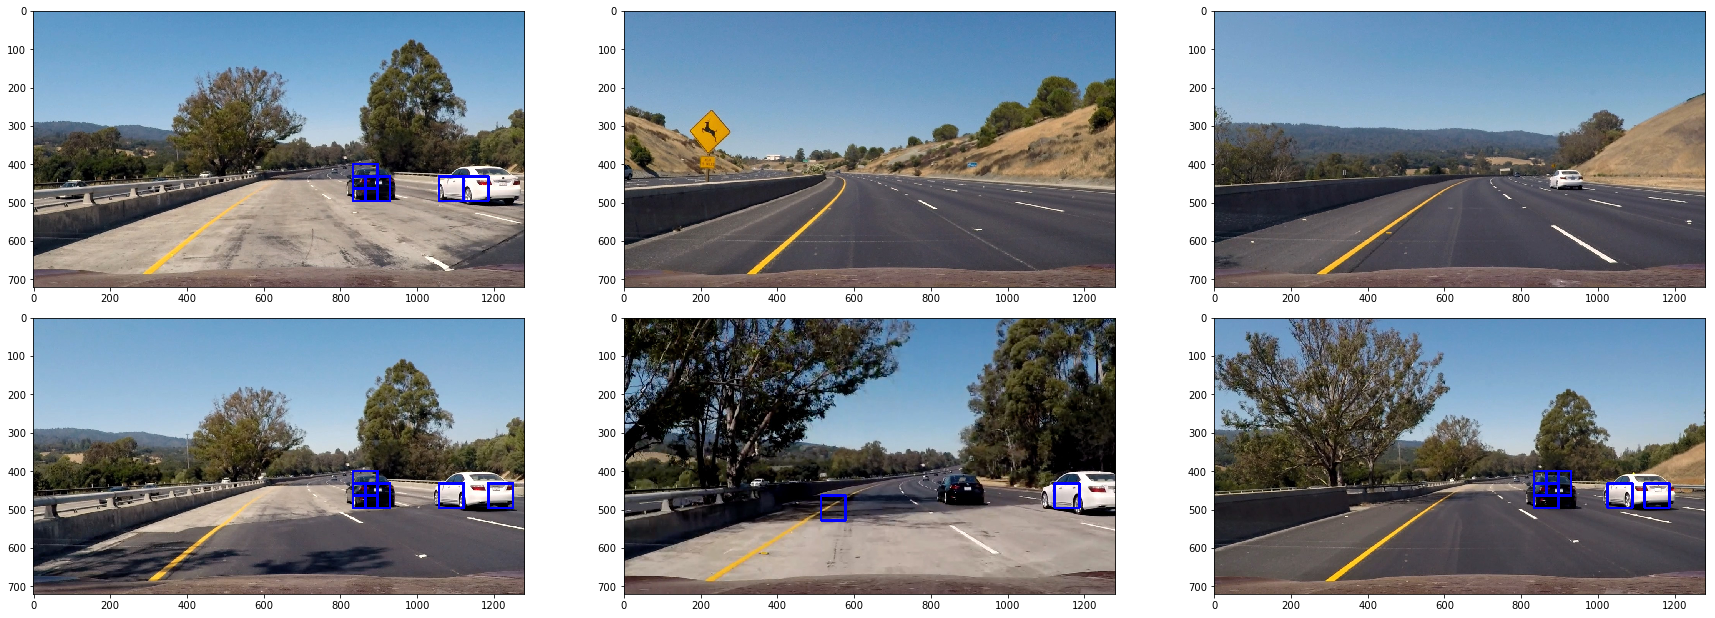

In [738]:
ystart =400
ystop = 720
xstart=0
xstop=1280
scale =1
cells_per_step = 2

t=time.time()
f, axes = plt.subplots(2, 3, figsize=(24, 9))
f.tight_layout()
i=0
boxes_list=[]
for fname in test_imgs:
    img = cv2.imread(fname)
    boxes = find_cars(img, color_space,ystart, ystop,xstart,xstop, scale, svc, X_scaler, orient, 
                      pix_per_cell, cell_per_block,cells_per_step, spatial_size, hist_bins)
    boxes_list.append(boxes)
    draw_img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    out_img=draw_boxes(draw_img, boxes, color=(0, 0, 255), thick=6)
    
    axes[i//3,i%3].imshow(out_img)
    i+=1
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.savefig('output_images/sliding_window_result.jpg')
t2 = time.time()
print(round(t2-t, 2), 'Seconds to predict samples...')

In [456]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img,color_space, ystart, ystop,xstart,xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,cells_per_step, spatial_size, hist_bins):
    boxes=[]
    #draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    #ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    #ctrans_tosearch = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if color_space != 'RGB':
        if color_space == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img_tosearch)  
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    #ch1_flip = (cv2.flip(ctrans_tosearch,1))[:,:,0]
    #ch2_flip = (cv2.flip(ctrans_tosearch,1))[:,:,1]
    #ch3_flip = (cv2.flip(ctrans_tosearch,1))[:,:,2]
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    #hog1_flip = get_hog_features(ch1_flip, orient, pix_per_cell, cell_per_block, feature_vec=False)
    #hog2_flip = get_hog_features(ch2_flip, orient, pix_per_cell, cell_per_block, feature_vec=False)
    #hog3_flip = get_hog_features(ch3_flip, orient, pix_per_cell, cell_per_block, feature_vec=False)    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            #hog_feat1_flip = hog1_flip[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            #hog_feat2_flip = hog2_flip[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            #hog_feat3_flip = hog3_flip[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()             
            #hog_features = np.hstack((hog_feat1,hog_feat1_flip, hog_feat2,hog_feat2_flip, hog_feat3,hog_feat3_flip))
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (window,window))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))  
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_feat1)).reshape(1, -1))
            #test_features = X_scaler.transform(hog_feat1.reshape(1, -1))
            #test_features = X_scaler.transform(np.hstack((hog_feat3, hog_feat2, hog_feat1)).reshape(1, -1))
            #test_features = X_scaler.transform(hog_features.reshape(1, -1)) 
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1 :
                xbox_left = np.int(xleft*scale)+xstart
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                boxes.append(((int(xbox_left), int(ytop_draw+ystart)),(int(xbox_left+win_draw),
                                                                       int(ytop_draw+win_draw+ystart))))
                #heatmap = add_heat(heat, boxes)
    return boxes#,heatmap


In [35]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    box_list = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        box_list.append(bbox)
    # Return the image
    return img , box_list

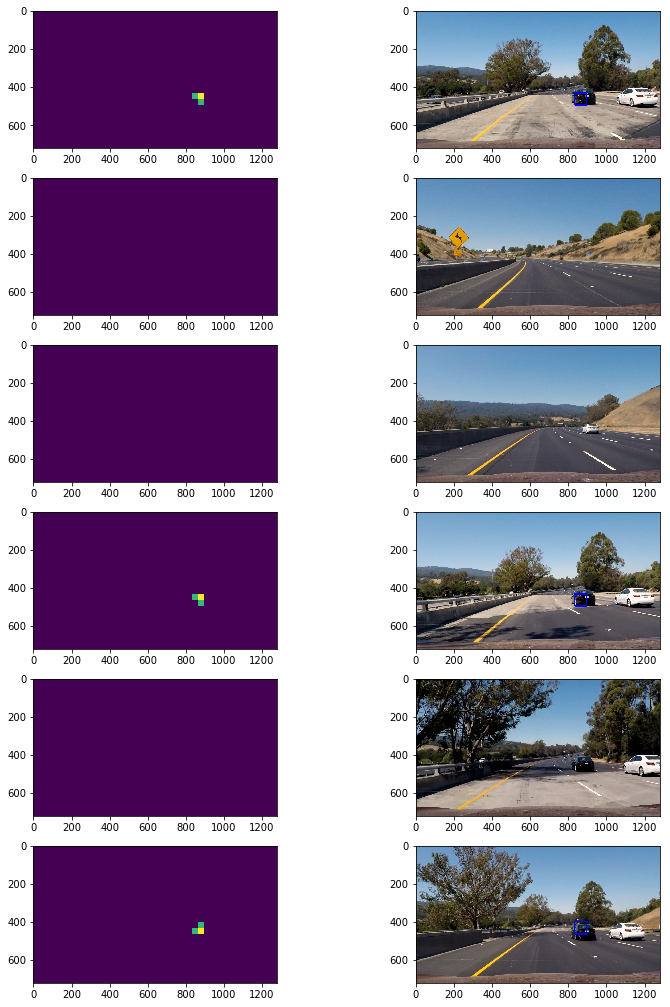

In [739]:
f, axes = plt.subplots(6, 2, figsize=(10, 15))
i=0
for fname in test_imgs:
    img = cv2.imread(fname)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,boxes_list[i])
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    f.tight_layout()    
    axes[i,0].imshow(heatmap)
    axes[i,1].imshow(draw_img)
    i+=1
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
plt.savefig('output_images/bboxes_and_heat.jpg')


In [721]:
def process_image(img):
    global n_frames, boxes_all
    boxes=[]
    
    xstart=400
    xstop=1280
    
    cells_per_step = 2#3

    ystart = 400#400
    ystop = 496#656
    scale =0.75
    
    boxes.extend(find_cars(img, color_space,ystart, ystop,xstart,xstop, scale, svc, X_scaler, orient, 
                                 pix_per_cell, cell_per_block, cells_per_step, spatial_size, hist_bins))
    ystart = 400#400
    ystop = 464#656  
    scale =1
    boxes.extend(find_cars(img, color_space,ystart, ystop,xstart,xstop, scale, svc, X_scaler, orient, 
                                 pix_per_cell, cell_per_block, cells_per_step, spatial_size, hist_bins))
    ystart = 416
    ystop = 480
    scale = 1.0
    boxes.extend(find_cars(img, color_space,ystart, ystop,xstart,xstop, scale, svc, X_scaler, orient, 
                                 pix_per_cell, cell_per_block, cells_per_step, spatial_size, hist_bins))

    ystart = 400
    ystop = 496
    scale = 1.5
    boxes.extend(find_cars(img, color_space,ystart, ystop,xstart,xstop, scale, svc, X_scaler, orient, 
                                 pix_per_cell, cell_per_block, cells_per_step, spatial_size, hist_bins))
    ystart = 432
    ystop = 528
    scale = 1.5
    boxes.extend(find_cars(img, color_space,ystart, ystop,xstart,xstop, scale, svc, X_scaler, orient, 
                                 pix_per_cell, cell_per_block,  cells_per_step, spatial_size, hist_bins))
    xstart=360
    xstop=1280
    
    #cells_per_step = 3
    ystart = 400
    ystop = 528
    
    scale = 2.0
    boxes.extend(find_cars(img, color_space,ystart, ystop,xstart,xstop, scale, svc, X_scaler, orient, 
                                 pix_per_cell, cell_per_block,  cells_per_step, spatial_size, hist_bins))
    ystart = 432
    ystop = 560

    scale = 2.0
    boxes.extend(find_cars(img, color_space,ystart, ystop,xstart,xstop, scale, svc, X_scaler, orient, 
                                 pix_per_cell, cell_per_block, cells_per_step,  spatial_size, hist_bins))
    ystart = 400
    ystop = 596
    scale = 3.5
    boxes.extend(find_cars(img, color_space,ystart, ystop,xstart,xstop, scale, svc, X_scaler, orient, 
                                 pix_per_cell, cell_per_block,cells_per_step, spatial_size, hist_bins))
    ystart = 464
    ystop = 700
    scale = 3.5
    boxes.extend(find_cars(img, color_space,ystart, ystop,xstart,xstop, scale, svc, X_scaler, orient, 
                                 pix_per_cell, cell_per_block, cells_per_step,  spatial_size, hist_bins))
    

    n_boxes.append(boxes)
    if n_frames<3:
        boxes_all.extend(boxes)
        n_frames+=1
    else :
        del boxes_all[0:len(n_boxes[0])]
        boxes_all.extend(boxes)
        del n_boxes[0]

    heat = np.zeros_like(img[:,:,0])
    # Add heat to each box in box list
    heat = add_heat(heat,boxes_all)
    # Apply threshold to help remove false positives
    thre=np.max([len(n_boxes[i]) for i in range(n_frames)])
    if thre<7:
        heat = apply_threshold(heat,1+thre)
    else:
        heat = apply_threshold(heat,8)
    # Visualize the heatmap when displaying    
    #heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heat)
    draw_img = draw_labeled_bboxes(img, labels)
    
    return draw_img

boxes=[]
boxes_all=[]
n_boxes=[]
n_frames=0

In [722]:
clip1 = VideoFileClip("project_video.mp4")#.subclip(20,26)#.subclip(38,40)#.subclip(17,19)#.subclip(0,9)#.subclip(20,26)##.subclip(15,20)#
#clip1 = VideoFileClip("test_video.mp4")
#clip1 = VideoFileClip("challenge_video.mp4").subclip(0,5)
#clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(process_image)

lanes_video = 'vehicle-detected-result.mp4'
%time white_clip.write_videofile(lanes_video, audio=False)

[MoviePy] >>>> Building video vehicle-detected-result.mp4
[MoviePy] Writing video vehicle-detected-result.mp4


100%|█████████▉| 1260/1261 [09:55<00:00,  2.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: vehicle-detected-result.mp4 

CPU times: user 9min 24s, sys: 27.9 s, total: 9min 52s
Wall time: 9min 57s
